Lightswitch PLR
===============

This example demonstrates how to use the ``.light_stamper(...)`` and ``.pupil_grabber(...)`` methods to measure and plot a simple PLR relative to light onset. The light source used for this example was a lightswitch in a dark room, but any light source given a suitable geometry will suffice.


Waiting for a light to stamp...
Grabbing 10 seconds of pupil.1.3d
Waiting for futures...
Light stamped on frame.world at 30656.814154
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
PupilGrabber done grabbing 10 seconds of pupil.1.3d


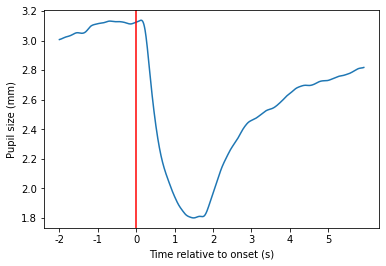

In [3]:
from time import sleep

import numpy as np

from pyplr.pupil import PupilCore
from pyplr.utils import unpack_data_pandas
from pyplr.preproc import butterworth_series

# Some constants
SAMPLE_RATE = 120
BASELINE = 2
DURATION = 6
ONSET = BASELINE*SAMPLE_RATE

# Set up pupil core
p = PupilCore()

# Annotation to be sent when the light comes on
annotation = p.new_annotation('LIGHT_ON')
    
# Start LightStamper and PupilGrabber
lst_future = p.light_stamper(
    annotation, 
    threshold=15, 
    timeout=DURATION)
pgr_future = p.pupil_grabber(
    topic='pupil.1.3d', 
    seconds=BASELINE+DURATION+2)
    
# Wait a few seconds...
sleep(BASELINE)

####################
# Shine the light! #
####################

while lst_future.running() or pgr_future.running():
    print('Waiting for futures...')
    sleep(1)

# Retrieve and process pupil data
data = unpack_data_pandas(pgr_future.result())
data = butterworth_series(
    data, 
    filt_order=3, 
    cutoff_freq=4/(SAMPLE_RATE/2), 
    fields=['diameter_3d'])

# Light_stamper timestamp
ts = lst_future.result()[1]

# Find the closest timestamp in the pupil data
idx = (np.abs(ts - data.index)).argmin()

# Trim and plot
start = idx-BASELINE*SAMPLE_RATE
end = idx+DURATION*SAMPLE_RATE
data = data.iloc[start:end]
data.reset_index(inplace=True)
ax = data['diameter_3d'].plot()
ax.axvline(x=ONSET, color='r')
ax.set_xticks(range(0,len(data), SAMPLE_RATE+1))
ax.set_xticklabels(range(-BASELINE,DURATION))
ax.set_ylabel('Pupil size (mm)')
ax.set_xlabel('Time relative to onset (s)')